This procedure aims to analyze the NAFLD dataset using NAFLD GCN.

In [1]:
# This procedure aims to analyze the NAFLD dataset using NAFLD GCN
import sys
sys.path.append('../src')
import abd_profile
import GCN
import warnings
import pandas as pd
import os
import copy
import analysis
import matplotlib.pyplot as plt
from matplotlib_venn import venn2, venn3
import completeness as cplt
import subprocess

warnings.filterwarnings('ignore')

# load data of NAFLD
outdir = '../result/NAFLD'
if not os.path.exists(outdir):
    os.makedirs(outdir)
ori_profile = abd_profile.input_profile('../data/NAFLD/abd.tsv' , transfer=True)
ori_GCN = GCN.input_GCN('../data/NAFLD/NASH_GCN.tsv', transfer=True)
print(ori_profile.shape)
print(ori_GCN.shape)
metadata = pd.read_csv('../data/NAFLD/NASH_forward_63_map.txt', sep = '\t', header=0, index_col=0)


(63, 97)
(4324, 97)


Compute the distance for NAFLD GCN.

In [2]:
# compute the distance
d_df = GCN.sp_d(ori_GCN)
params = {
    'sample cluster': 'enterotype', # 'enterotype', # can be 'seat'
    'max_cluster': 10,
    'max_depth': 6
}
d_df.to_csv('../data/NAFLD/NASH_distance.tsv', sep = '\t')

Separate samples according to phenotype.

Build personalized functional redundancy network and construct the tree for each phenotypes.  

Find the keystone speceis and keystone clsuter for each phenotype.

In [3]:
# Separate samples according to phenotype
cluster_labels = list(set(metadata['DiseaseStatus']))
label_dict = {}
cluster_profiles = {}
phenos = ['NASH', 'Normal']
for pheno in phenos:
    idx_list = list(metadata[metadata['DiseaseStatus'] == pheno].index)
    cluster_profiles[pheno] = copy.deepcopy(ori_profile.loc[idx_list, :])

# build personalized functional redundancy network and construct the tree for each phenotypes
# find the keystone speceis and keystone clsuter
result, c = analysis.main(ori_GCN, ori_profile, outdir, params, d_df, cluster_profiles)


Check the difference of keystone speceis and keystone cluster

In [4]:
# check the difference of keystone speceis and keystone cluster
sp_dict  = {}
for pheno in phenos:
    cdir = os.path.join(outdir, 'cluster_{}'.format(pheno))
    keystone_path = os.path.join(cdir, 'keystone_node.tsv')
    keystone_df = pd.read_csv(keystone_path, sep='\t', header=0, index_col=0)
    keystone_cluster  = (keystone_df[(keystone_df['is_keystone'] == True) & (keystone_df['layer'] == 1)])['leaves'].iloc[0].split(',')
    sp_dict[pheno] = copy.deepcopy(set(keystone_cluster))

common = sp_dict[phenos[0]].intersection(sp_dict[phenos[1]])
diff0 = sp_dict[phenos[0]].difference(sp_dict[phenos[1]])
diff1 = sp_dict[phenos[1]].difference(sp_dict[phenos[0]])

print('Common: {} species: \n{}\n'.format(len(common), '\n'.join(sorted(list(common)))))


Common: 6 species: 
s__A. ruminis-OTU75
s__B. barnesiae
s__B. caecicola-OTU4
s__B. producta-OTU32
s__F. prausnitzii-OTU8
s__F. prausnitzii-OTU80



In [5]:
# Check the difference of keystone species and keystone clusters

phenos = ["NASH", "Normal"]  # Assuming these are your phenotypes

# Dictionary to store cluster species for each phenotype
sp_dict = {}
# Dictionary to store keystone species for each phenotype
keystone_species_dict = {}


for pheno in phenos:
    cdir = os.path.join(outdir, 'cluster_{}'.format(pheno))
    keystone_path = os.path.join(cdir, 'keystone_node.tsv')
    keystone_df = pd.read_csv(keystone_path, sep='\t', header=0, index_col=0)
    
    # Get keystone clusters (layer=1 and is_keystone=True)
    keystone_cluster = (keystone_df[(keystone_df['is_keystone'] == True) & (keystone_df['layer'] == 1)])['leaves'].iloc[0].split(',')
    sp_dict[pheno] = copy.deepcopy(set(keystone_cluster))
    
    # Get the single keystone species (layer=0 and is_keystone=True)
    keystone_species_row = keystone_df[(keystone_df['is_keystone'] == True) & (keystone_df['layer'] == 0)]
    if not keystone_species_row.empty:
        keystone_species = keystone_species_row.index[0]  # Get the single keystone species
        keystone_species_dict[pheno] = keystone_species
    else:
        print(f"Warning: No keystone species found for {pheno}")
        keystone_species_dict[pheno] = None


# Store results in specific variables
FR_NASH_keystone_list = sp_dict[phenos[0]]
FR_Normal_keystone_list = sp_dict[phenos[1]]

# Print cluster comparison
common_clusters = FR_NASH_keystone_list.intersection(FR_Normal_keystone_list)
diff_nash_clusters = FR_NASH_keystone_list.difference(FR_Normal_keystone_list)
diff_normal_clusters = FR_Normal_keystone_list.difference(FR_NASH_keystone_list)

print('=== Keystone Cluster Comparison ===')
print('Common clusters: {} species: \n{}\n'.format(len(common_clusters), '\n'.join(sorted(list(common_clusters)))))
print('In {} only clusters: {} species: \n{}\n'.format(phenos[0], len(diff_nash_clusters), '\n'.join(sorted(list(diff_nash_clusters)))))
print('In {} only clusters: {} species: \n{}\n'.format(phenos[1], len(diff_normal_clusters), '\n'.join(sorted(list(diff_normal_clusters)))))


=== Keystone Cluster Comparison ===
Common clusters: 6 species: 
s__A. ruminis-OTU75
s__B. barnesiae
s__B. caecicola-OTU4
s__B. producta-OTU32
s__F. prausnitzii-OTU8
s__F. prausnitzii-OTU80

In NASH only clusters: 15 species: 
s__A. octavius
s__B. coprophilus
s__C. pinnipediorum
s__D. pneumosintes
s__E. peruensis
s__Escherichia-Shigella-OTU88
s__Ezakiella-OTU94
s__F. magna
s__P. buccalis
s__P. ivorii
s__P. lacrimalis
s__P. loveana
s__P. olsenii
s__P. sp. 2007b
s__S5-A14a-OTU76

In Normal only clusters: 19 species: 
s__A. caccae
s__A. indistinctus-OTU57
s__B. caecicola-OTU51
s__B. coprosuis-OTU67
s__B. hydrogenotrophica
s__B. magnum
s__B. producta-OTU81
s__C. comes
s__D. formicigenerans
s__D. longicatena
s__E. oxidoreducens
s__F. saccharivorans
s__P. chartae-OTU69
s__R. gnavus
s__R. torques
s__Ruminiclostridium-OTU96
s__Ruminococcaceae-OTU46
s__S. variabile-OTU44
s__S. variabile-OTU93



In [6]:
FR_NASH_keystone_species = keystone_species_dict[phenos[0]]
FR_Normal_keystone_species = keystone_species_dict[phenos[1]]
# Print keystone species information
print('=== Keystone Species Information ===')
print(f"{phenos[0]} keystone species: {FR_NASH_keystone_species}")
print(f"{phenos[1]} keystone species: {FR_Normal_keystone_species}")


=== Keystone Species Information ===
NASH keystone species: s__B. caecicola-OTU4
Normal keystone species: s__B. caecicola-OTU4


In [7]:
def remove_prefix(species_set, prefix="s__"):
    """
    remove prefix form species set
    
    params:
    species_set (set): set of species name
    prefix (str):  prefix to be removed, default "s__"

    return:
    set: set of species name after removing prefix
    """
    processed_set = set()
    for species in species_set:
        if isinstance(species, str) and species.startswith(prefix):
            processed_set.add(species[len(prefix):])  # remove prefix
        else:
            processed_set.add(species)  # keep original if no prefix or not a string

    return processed_set

In [8]:
FR_NASH_keystone_list = sp_dict[phenos[0]]
FR_Normal_keystone_list = sp_dict[phenos[1]]
FR_NASH_keystone_list = remove_prefix(FR_NASH_keystone_list)
FR_Normal_keystone_list = remove_prefix(FR_Normal_keystone_list)


In [10]:

# Compare with differential abundance species

# load data
file_path = "../result/NAFLD/NASH.Normal.abundance.wilcox_testing.tsv"
data = pd.read_csv(file_path, sep='\t', index_col=0)


# filter species with increased abundance in NASH (fc > 1 and p_adj < 0.05)
NASH_abd_df = data[(data['fc(case/control)'] > 1) & (data['p_adj'] < 0.05)]
print(f"\nNumber of species whose abundance increase in NASH: {NASH_abd_df.shape[0]}")

# filter species with increased abundance in Normal (fc < 1 and p_adj < 0.05)
Normal_abd_df = data[(data['fc(case/control)'] < 1) & (data['p_adj'] < 0.05)]
print(f"Number of species whose abundance increase in Normal: {Normal_abd_df.shape[0]}")

# create species set and remove "s__" prefix
# process DataFrame index example
NASH_abd_list = remove_prefix(set(NASH_abd_df.index))
Normal_abd_list = remove_prefix(set(Normal_abd_df.index))




Number of species whose abundance increase in NASH: 16
Number of species whose abundance increase in Normal: 19


=== Basic Information ===
FR_NASH_keystone_list: 21 species
FR_Normal_keystone_list: 25 species
NASH_abd_list: 16 species
Normal_abd_list: 19 species


<Figure size 1800x1500 with 0 Axes>

<Figure size 1800x1500 with 0 Axes>

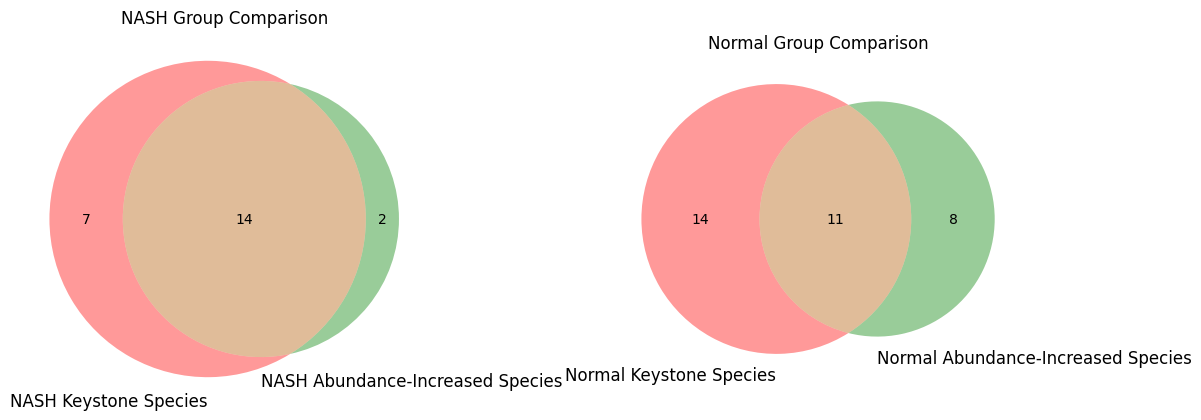

In [11]:
# Create Venn diagram visualization


# Print basic information about each set
print("=== Basic Information ===")
print(f"FR_NASH_keystone_list: {len(FR_NASH_keystone_list)} species")
print(f"FR_Normal_keystone_list: {len(FR_Normal_keystone_list)} species")
print(f"NASH_abd_list: {len(NASH_abd_list)} species")
print(f"Normal_abd_list: {len(Normal_abd_list)} species")


# Create figure with 2 subplots
plt.figure(figsize=(12, 5))

# NASH Venn diagram
plt.subplot(1, 2, 1)
venn2([FR_NASH_keystone_list, NASH_abd_list], 
        ('NASH Keystone Species', 'NASH Abundance-Increased Species'))
plt.title('NASH Group Comparison')

# Normal Venn diagram
plt.subplot(1, 2, 2)
venn2([FR_Normal_keystone_list, Normal_abd_list], 
        ('Normal Keystone Species', 'Normal Abundance-Increased Species'))
plt.title('Normal Group Comparison')

plt.tight_layout()
plt.savefig(os.path.join(outdir, 'keystone_abundance_comparison.png'), dpi=300)
plt.show()


In [12]:
# Compare keystone species with abundance-changed species
print("\n=== Comparison between Keystone Species and Abundance-Changed Species ===")

# For NASH group
nash_keystone_abd_overlap = FR_NASH_keystone_list.intersection(NASH_abd_list)
nash_keystone_only = FR_NASH_keystone_list - NASH_abd_list
nash_abd_only = NASH_abd_list - FR_NASH_keystone_list

print("\n--- NASH Group ---")
print(f"Species that are both keystone and abundance-increased in NASH: {len(nash_keystone_abd_overlap)}")
print(f"Species that are keystone only (without abundance change) in NASH: {len(nash_keystone_only)}")
print(sorted(list(nash_keystone_only)))

# For Normal group
normal_keystone_abd_overlap = FR_Normal_keystone_list.intersection(Normal_abd_list)
normal_keystone_only = FR_Normal_keystone_list - Normal_abd_list
normal_abd_only = Normal_abd_list - FR_Normal_keystone_list

print("\n--- Normal Group ---")
print(f"Species that are both keystone and abundance-increased in Normal: {len(normal_keystone_abd_overlap)}")
print(f"Species that are keystone only (without abundance change) in Normal: {len(normal_keystone_only)}")
print(sorted(list(normal_abd_only)))



=== Comparison between Keystone Species and Abundance-Changed Species ===

--- NASH Group ---
Species that are both keystone and abundance-increased in NASH: 14
Species that are keystone only (without abundance change) in NASH: 7
['A. ruminis-OTU75', 'B. barnesiae', 'B. caecicola-OTU4', 'B. coprophilus', 'B. producta-OTU32', 'F. prausnitzii-OTU8', 'F. prausnitzii-OTU80']

--- Normal Group ---
Species that are both keystone and abundance-increased in Normal: 11
Species that are keystone only (without abundance change) in Normal: 14
['B. caecicola-OTU72', 'B. hansenii', 'B. propionicifaciens-OTU73', 'E. rectale-OTU52', 'F. prausnitzii-OTU79', 'Lachnospiraceae-OTU55', 'R. lactaris-OTU43', 'R. lituseburensis']


In [13]:
# file path
keystone_file_path = "../data/NAFLD/keystone.list" 

# load NASH file and convert to set
keystone_list = set()

with open(keystone_file_path, 'r') as file:
    for line in file:
        item = line.strip()
        if item:  # ensure no empty lines are added
            keystone_list.add(item)
print(f"Successfully read {len(keystone_list)} elements from {keystone_file_path}")



Successfully read 8 elements from ../data/NAFLD/keystone.list


In [14]:
FR_NASH_keystone_list

{'A. octavius',
 'A. ruminis-OTU75',
 'B. barnesiae',
 'B. caecicola-OTU4',
 'B. coprophilus',
 'B. producta-OTU32',
 'C. pinnipediorum',
 'D. pneumosintes',
 'E. peruensis',
 'Escherichia-Shigella-OTU88',
 'Ezakiella-OTU94',
 'F. magna',
 'F. prausnitzii-OTU8',
 'F. prausnitzii-OTU80',
 'P. buccalis',
 'P. ivorii',
 'P. lacrimalis',
 'P. loveana',
 'P. olsenii',
 'P. sp. 2007b',
 'S5-A14a-OTU76'}

In [15]:
# Calculate intersections and differences
keystone_in_NASH = keystone_list.intersection(FR_NASH_keystone_list)
keystone_in_Normal = keystone_list.intersection(FR_Normal_keystone_list)
keystone_in_both = keystone_in_NASH.intersection(keystone_in_Normal)
keystone_only = keystone_list - (FR_NASH_keystone_list.union(FR_Normal_keystone_list))
NASH_only = FR_NASH_keystone_list - keystone_list
Normal_only = FR_Normal_keystone_list - keystone_list

# Print comparison results
print(f"Total species in literature keystone_list: {len(keystone_list)}")
print(f"Total species in FR_NASH_keystone_list: {len(FR_NASH_keystone_list)}")
print(f"Total species in FR_Normal_keystone_list: {len(FR_Normal_keystone_list)}")
print(f"\nIntersection between literature keystone_list and FR_NASH_keystone_list: {len(keystone_in_NASH)} species")
if keystone_in_NASH:
    print("Intersection species:")
    for i, species in enumerate(sorted(keystone_in_NASH), 1):
        print(f"  {i}. {species}")

print(f"\nIntersection between literature keystone_list and FR_Normal_keystone_list: {len(keystone_in_Normal)} species")
if keystone_in_Normal:
    print("Intersection species:")
    for i, species in enumerate(sorted(keystone_in_Normal), 1):
        print(f"  {i}. {species}")

print(f"\nSpecies appearing in all three lists: {len(keystone_in_both)} species")
if keystone_in_both:
    print("Common species:")
    for i, species in enumerate(sorted(keystone_in_both), 1):
        print(f"  {i}. {species}")

print(f"\nSpecies exclusive to literature keystone_list: {len(keystone_only)} species")
if len(keystone_only) > 0 and len(keystone_only) <= 20:  # Print all if quantity is moderate
    print("Exclusive species:")
    for i, species in enumerate(sorted(keystone_only), 1):
        print(f"  {i}. {species}")
elif len(keystone_only) > 20:  # Print only part if too many
    print("Exclusive species (first 20):")
    for i, species in enumerate(sorted(list(keystone_only))[:20], 1):
        print(f"  {i}. {species}")
    print(f"  ... {len(keystone_only)-20} more species not displayed")

Total species in literature keystone_list: 8
Total species in FR_NASH_keystone_list: 21
Total species in FR_Normal_keystone_list: 25

Intersection between literature keystone_list and FR_NASH_keystone_list: 5 species
Intersection species:
  1. B. barnesiae
  2. B. producta-OTU32
  3. D. pneumosintes
  4. Escherichia-Shigella-OTU88
  5. P. loveana

Intersection between literature keystone_list and FR_Normal_keystone_list: 4 species
Intersection species:
  1. A. caccae
  2. A. indistinctus-OTU57
  3. B. barnesiae
  4. B. producta-OTU32

Species appearing in all three lists: 2 species
Common species:
  1. B. barnesiae
  2. B. producta-OTU32

Species exclusive to literature keystone_list: 1 species
Exclusive species:
  1. Lachnospiraceae-OTU85


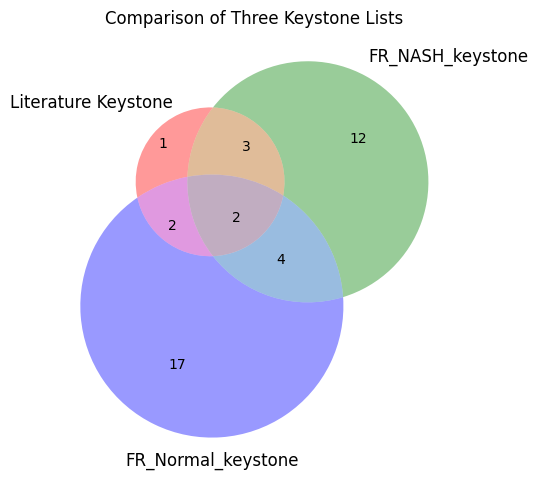

In [16]:
# Venn plot

plt.figure(figsize=(10, 10))


plt.subplot(1, 2, 1)
venn3([keystone_list, FR_NASH_keystone_list, FR_Normal_keystone_list], 
      ('Literature Keystone', 'FR_NASH_keystone', 'FR_Normal_keystone'))
plt.title('Comparison of Three Keystone Lists')

plt.tight_layout()
plt.savefig(os.path.join(outdir, 'keystone_comparison.png'), dpi=300)
plt.show()


In [17]:
# This script computes the completeness for the NAFLD GCN

# load module defination and GCN
input_df = pd.read_csv('../data/module_def0507.tsv', sep='\t', header=0, index_col=0)
df = pd.read_csv('../data/NAFLD/NASH_GCN.tsv', sep='\t', header=0, index_col=0)

out_df = pd.DataFrame(index=df.index,columns=input_df.index) 
for index, row in df.iterrows():
  # print(index)
  ko_list = []
  for col, value in row.items():
    #print(col,value)
    if value != 0:
      ko_list.append(col)
  if not ko_list:  
    continue

  for idx in input_df.index:
    definition = input_df.loc[idx, 'def']
    node_dict, nid = cplt.replace_branket(definition)
    definition, mdict = cplt.replace_module(input_df, definition)
    new_node_dict, nid = cplt.replace_branket(definition, nid)
    node_dict = {**mdict, **node_dict, **new_node_dict}
    path = cplt.main(definition,ko_list, node_dict)
    value = path['exist']/path['length']
    value = round(value, 4)
    out_df.loc[index, idx] = value
    
odir = '../result/NAFLD'
if not os.path.exists(odir):
  os.makedirs(odir)
out_df.to_csv(os.path.join(odir, 'genome_module.completeness.tsv'), sep='\t')


In [18]:
FR_NASH_keystone_list = sp_dict[phenos[0]]
FR_Normal_keystone_list = sp_dict[phenos[1]]

In [19]:
def generate_cluster_species_file(keystone_list, all_species, output_file, group_name):
    """
    Generate a cluster species text file with the format:
    Group_keystone    species_name  (for keystone species)
    Other             species_name  (for non-keystone species)
    
    Args:
        keystone_list: Set of keystone species
        all_species: List of all species (e.g., column names from ori_profile)
        output_file: Output file path
        group_name: Group name (e.g., "NASH" or "Normal")
    """
    # Get all species from ori_profile columns
    with open(output_file, 'w') as f:
        # Write keystone species first
        for species in sorted(keystone_list):
            # Check if the species exists in the profile data
            if species in all_species or f"s__{species}" in all_species:
                species_name = species if species in all_species else f"s__{species}"
                f.write(f"{group_name}_keystone\t{species_name}\n")
        
        # Write other species
        for species in sorted(all_species):
            # Skip species name if it's already in keystone list (with or without prefix)
            species_no_prefix = species[3:] if species.startswith("s__") else species
            if species_no_prefix in keystone_list or species in keystone_list:
                continue
            f.write(f"Other\t{species}\n")
    
    print(f"Created {output_file} successfully")

# Get all species from ori_profile columns
all_species = list(ori_profile.columns)
odir = '../result/NAFLD'
# Generate files for NASH and Normal groups
generate_cluster_species_file(
    FR_NASH_keystone_list, 
    all_species, 
    f"{odir}/NASH.cluster_species.txt", 
    "NASH"
)

generate_cluster_species_file(
    FR_Normal_keystone_list, 
    all_species, 
    f"{odir}/Normal.cluster_species.txt", 
    "Normal"
)


Created ../result/NAFLD/NASH.cluster_species.txt successfully
Created ../result/NAFLD/Normal.cluster_species.txt successfully


In [20]:
# check if Rscript exists
python_executable = sys.executable
python_dir = os.path.dirname(python_executable)
rscript_path = os.path.join(python_dir, 'Rscript')
if os.path.exists(rscript_path):
    print(f"Rscript path: {rscript_path}")
else:
    print(f"Could not find Rscript in Python directory: {rscript_path}")
    print("Please ensure R is installed in your conda environment")

Rscript path: /home/chelijia/anaconda3/envs/meta_fr_r/bin/Rscript


In [21]:
#  completeness testing
cmd_args = [
    rscript_path, 
    "../02.script_signature_modules/cluster_completeness_testing.R",
    "genome_module.completeness.tsv", 
    "NASH.cluster_species.txt", 
    "NASH.module_comp.wilcox.testing.tsv", 
    outdir
]
try:
    print(f"Executing: {' '.join(cmd_args)}")
    result = subprocess.run(cmd_args, capture_output=True, text=True)
except Exception as e:
    print(f"Exception occurred while processing: {e}")    
print(f"Done")

#  completeness testing
cmd_args = [
    rscript_path, 
    "../02.script_signature_modules/cluster_completeness_testing.R",
    "genome_module.completeness.tsv", 
    "Normal.cluster_species.txt", 
    "Normal.module_comp.wilcox.testing.tsv", 
    outdir
]
try:
    print(f"Executing: {' '.join(cmd_args)}")
    result = subprocess.run(cmd_args, capture_output=True, text=True)
except Exception as e:
    print(f"Exception occurred while processing: {e}")    
print(f"Done")

Executing: /home/chelijia/anaconda3/envs/meta_fr_r/bin/Rscript ../02.script_signature_modules/cluster_completeness_testing.R genome_module.completeness.tsv NASH.cluster_species.txt NASH.module_comp.wilcox.testing.tsv ../result/NAFLD
Done
Executing: /home/chelijia/anaconda3/envs/meta_fr_r/bin/Rscript ../02.script_signature_modules/cluster_completeness_testing.R genome_module.completeness.tsv Normal.cluster_species.txt Normal.module_comp.wilcox.testing.tsv ../result/NAFLD
Done


In [22]:
# Read and filter NASH results
wilcox_file_nash = os.path.join(outdir, "NASH.module_comp.wilcox.testing.tsv")
wilcox_df_nash = pd.read_csv(wilcox_file_nash, sep='\t')
significant_modules_nash = wilcox_df_nash[(wilcox_df_nash['pvalue'] < 0.05) & 
                                          (wilcox_df_nash['effect_size'] > 0.3) & 
                                          (wilcox_df_nash['cluster'] == "NASH_keystone")]

# Read and filter Normal results
wilcox_file_normal = os.path.join(outdir, "Normal.module_comp.wilcox.testing.tsv")
wilcox_df_normal = pd.read_csv(wilcox_file_normal, sep='\t')
significant_modules_normal = wilcox_df_normal[(wilcox_df_normal['pvalue'] < 0.05) & 
                                              (wilcox_df_normal['effect_size'] > 0.3) & 
                                              (wilcox_df_normal['cluster'] == "Normal_keystone")]


# Combine the two DataFrames
combined_significant_modules = pd.concat([significant_modules_nash, significant_modules_normal], ignore_index=True)

combined_significant_modules

,module,cluster,n_c,com_c,mean_c,var_c,n_not_c,com_not_c,mean_not_c,var_not_c,rank_sum,effect_size,pvalue,padj
0,M00165,NASH_keystone,21,1.000000,0.684014,0.003817,76,1.000000,0.639987,0.000979,1098.5,0.376566,0.000028,0.000372
1,M00364,NASH_keystone,21,1.000000,0.690476,0.061905,76,1.000000,0.519737,0.009605,1070.5,0.341479,0.000014,0.000299
2,M00365,NASH_keystone,21,0.380952,0.190476,0.061905,76,0.052632,0.026316,0.012632,1060.0,0.328321,0.000059,0.000640
3,M00367,NASH_keystone,21,0.380952,0.126971,0.027508,76,0.039474,0.013157,0.004268,1070.5,0.341479,0.000014,0.000299
4,M00611,NASH_keystone,21,1.000000,0.626976,0.003210,76,1.000000,0.586595,0.000823,1098.5,0.376566,0.000028,0.000372
5,M00612,NASH_keystone,21,1.000000,0.626976,0.003210,76,1.000000,0.586595,0.000823,1098.5,0.376566,0.000028,0.000372
6,M00938,NASH_keystone,21,1.000000,0.676190,0.025905,76,1.000000,0.560526,0.033088,1094.5,0.371554,0.006068,0.029056
7,M00014,Normal_keystone,25,1.000000,0.325000,0.009115,72,0.875000,0.239583,0.019256,1228.5,0.365000,0.004816,0.404290
8,M00554,Normal_keystone,25,0.960000,0.840000,0.077500,72,0.750000,0.590278,0.164270,1203.0,0.336667,0.006387,0.404290
9,M00632,Normal_keystone,25,1.000000,0.920000,0.019375,72,0.916667,0.718750,0.103763,1234.0,0.371111,0.002895,0.404290
